# Advanced Material Features #

This tutorial introduces more advanced ways of handling materials in FESTIM. A key addition in FESTIM 2.0 is the ability to perform multi-species simulations, which often requires assigning distinct material properties to each species (see __[documentation](https://festim.readthedocs.io/en/v2.0-alpha.3/api/index.html#festim.material.Material)__ for more information). In some cases, users may also need to define custom material properties—for example, specifying a turbulence-dependent viscosity or user-defined diffusion coefficient.

Objectives:
* Assign different material properties to different species
* Define custom material properties (e.g., diffusion coefficients)

## Assigning different material properties in a multi-species simulation ##

Consider the following 1D example that simulates the diffusion of protium, deuterium and tritium species:

In [96]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

protium = F.Species("H")
deuterium = F.Species("D")
tritium = F.Species("T")
my_model.species = [protium, deuterium, tritium]

my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

Here we define the different diffusivities for each species. The `mat` dictionary stores keys for each species' diffusion coefficient `D_0` and activation energy `E_D`. We define one domain for all species called `bulk` that serves as the volume for the material:

In [97]:
mat = F.Material(
    D_0={protium: 1.0e-3, deuterium: 3.0e-3, tritium: 5.0e-3},  # example diffusivity values for H, D, T
    E_D={protium: 0.0, deuterium: 0.0, tritium: 0.0},
)

# One bulk domain using this material
bulk = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat)

my_model.subdomains = [bulk, left_surf, right_surf]

To illustrate how different species' diffusion properties affect the simulation, we set the same boundary condition for each species (1 on the left boundary, 0 on the right) and run the simulation:

In [98]:
# Boundary conditions
my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=1, species=protium),
    F.FixedConcentrationBC(right_surf, value=0, species=protium),
    F.FixedConcentrationBC(left_surf, value=1, species=deuterium),
    F.FixedConcentrationBC(right_surf, value=0, species=deuterium),
    F.FixedConcentrationBC(left_surf, value=1, species=tritium),
    F.FixedConcentrationBC(right_surf, value=0, species=tritium),
]

Now we can run the simulation and look at the concentration profile for each species:

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

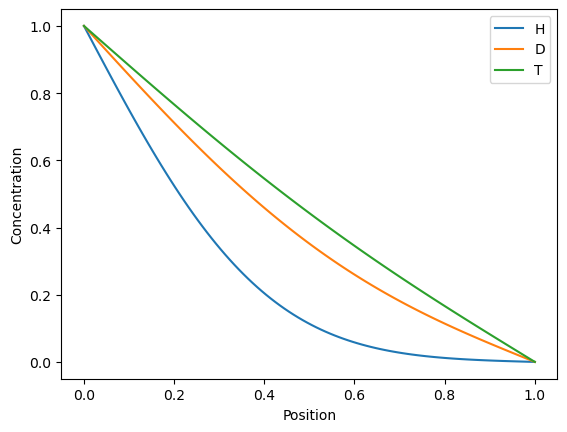

In [99]:
my_model.temperature = 300

my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)

my_model.settings.stepsize = F.Stepsize(1)
my_model.initialise()
my_model.run()

import matplotlib.pyplot as plt

def plot_profile(species, **kwargs):
    c = species.post_processing_solution.x.array[:]
    x = species.post_processing_solution.function_space.mesh.geometry.x[:,0]
    return plt.plot(x, c, **kwargs)

for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()

Compare this to the case where each species has the same diffusion properties:

Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

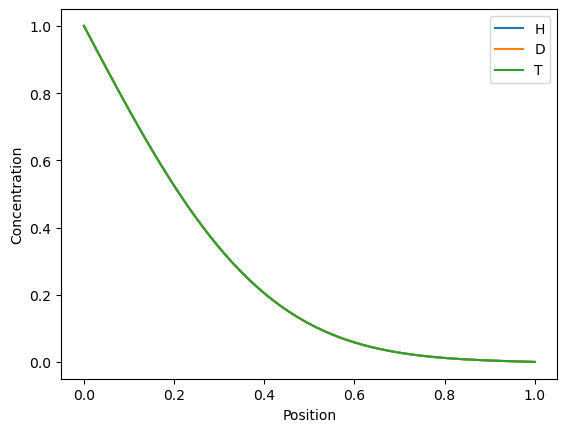

In [102]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

protium = F.Species("H")
deuterium = F.Species("D")
tritium = F.Species("T")
my_model.species = [protium, deuterium, tritium]

my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

mat = F.Material(
    D_0={protium: 1.0e-3, deuterium: 1.0e-3, tritium: 1.0e-3},  # example diffusivity values for H, D, T
    E_D={protium: 0.0, deuterium: 0.0, tritium: 0.0},
)

# One bulk domain using this material
bulk = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat)

my_model.subdomains = [bulk, left_surf, right_surf]
# Boundary conditions
my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=1, species=protium),
    F.FixedConcentrationBC(right_surf, value=0, species=protium),
    F.FixedConcentrationBC(left_surf, value=1, species=deuterium),
    F.FixedConcentrationBC(right_surf, value=0, species=deuterium),
    F.FixedConcentrationBC(left_surf, value=1, species=tritium),
    F.FixedConcentrationBC(right_surf, value=0, species=tritium),
]

my_model.temperature = 300
my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)
my_model.settings.stepsize = F.Stepsize(1)
my_model.initialise()
my_model.run()

import matplotlib.pyplot as plt

def plot_profile(species, **kwargs):
    c = species.post_processing_solution.x.array[:]
    x = species.post_processing_solution.function_space.mesh.geometry.x[:,0]
    return plt.plot(x, c, **kwargs)

for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## Defining custom material properties ##


Some cases will require user-defined material properties (such as in __[bubbly flows](https://doc.comsol.com/6.0/doc/com.comsol.help.cfd/cfd_ug_fluidflow_multi.09.142.html)__ or __[turbulence-assisted-diffusion](https://en.wikipedia.org/wiki/Turbulent_diffusion)__). For example, let's look at:


Solving HydrogenTransportProblem:   0%|          | 0.00/50.0 [00:00<?, ?it/s]

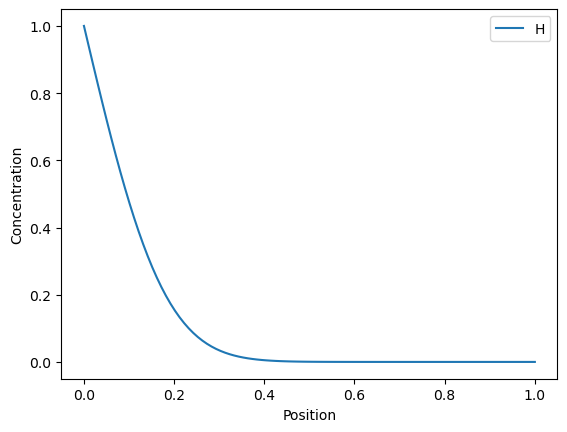

In [101]:
import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

species = F.Species("H")

my_model.species = [species]

my_model.mesh = F.Mesh1D(np.linspace(0, 1, 100))

left_surf = F.SurfaceSubdomain1D(id=1, x=0)
right_surf = F.SurfaceSubdomain1D(id=2, x=1)

custom_D0 = 2e-4  # Custom diffusion coefficient
mat = F.Material(D_0=custom_D0, E_D=0.0)

# One bulk domain using this material
bulk = F.VolumeSubdomain1D(id=1, borders=[0, 1], material=mat)

my_model.subdomains = [bulk, left_surf, right_surf]
# Boundary conditions
my_model.boundary_conditions = [
    F.FixedConcentrationBC(left_surf, value=1, species=species),
    F.FixedConcentrationBC(right_surf, value=0, species=species),
]

my_model.temperature = 300
my_model.settings = F.Settings(atol=1e-10, rtol=1e-10, final_time=50)
my_model.settings.stepsize = F.Stepsize(1)
my_model.initialise()
my_model.run()

import matplotlib.pyplot as plt

def plot_profile(species, **kwargs):
    c = species.post_processing_solution.x.array[:]
    x = species.post_processing_solution.function_space.mesh.geometry.x[:,0]
    return plt.plot(x, c, **kwargs)

for species in my_model.species:
    plot_profile(species, label=species.name)

plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()